The code is from [sklearn-crfsuite — sklearn-crfsuite 0.3 documentation](https://sklearn-crfsuite.readthedocs.io/en/latest/index.html)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

## Features

In [4]:
nltk.corpus.conll2002.fileids()

['esp.testa', 'esp.testb', 'esp.train', 'ned.testa', 'ned.testb', 'ned.train']

In [9]:
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))

In [27]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    # i > 0 时，选择前一个 token 的特征作为特征
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    # begin of string
    else:
        features['BOS'] = True
    
    # i < len(sent) - 1 时，选择后一个 token 的特征作为特征
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    # end of string
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [35]:
s2f0 = sent2features(train_sents[0])

In [36]:
s2f0[0]

{'bias': 1.0,
 'word.lower()': 'melbourne',
 'word[-3:]': 'rne',
 'word[-2:]': 'ne',
 'word.isupper()': False,
 'word.istitle()': True,
 'word.isdigit()': False,
 'postag': 'NP',
 'postag[:2]': 'NP',
 'BOS': True,
 '+1:word.lower()': '(',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:postag': 'Fpa',
 '+1:postag[:2]': 'Fp'}

In [37]:
s2f0[-1]

{'bias': 1.0,
 'word.lower()': '.',
 'word[-3:]': '.',
 'word[-2:]': '.',
 'word.isupper()': False,
 'word.istitle()': False,
 'word.isdigit()': False,
 'postag': 'Fp',
 'postag[:2]': 'Fp',
 '-1:word.lower()': ')',
 '-1:word.istitle()': False,
 '-1:word.isupper()': False,
 '-1:postag': 'Fpt',
 '-1:postag[:2]': 'Fp',
 'EOS': True}

In [38]:
s2f0[1]

{'bias': 1.0,
 'word.lower()': '(',
 'word[-3:]': '(',
 'word[-2:]': '(',
 'word.isupper()': False,
 'word.istitle()': False,
 'word.isdigit()': False,
 'postag': 'Fpa',
 'postag[:2]': 'Fp',
 '-1:word.lower()': 'melbourne',
 '-1:word.istitle()': True,
 '-1:word.isupper()': False,
 '-1:postag': 'NP',
 '-1:postag[:2]': 'NP',
 '+1:word.lower()': 'australia',
 '+1:word.istitle()': True,
 '+1:word.isupper()': False,
 '+1:postag': 'NP',
 '+1:postag[:2]': 'NP'}

In [39]:
sent2labels(train_sents[0])

['B-LOC', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O']

In [40]:
sent2tokens(train_sents[0])

['Melbourne', '(', 'Australia', ')', ',', '25', 'may', '(', 'EFE', ')', '.']

## Training

In [41]:
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

In [42]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=0.1, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

## Evaluation

In [43]:
labels = list(crf.classes_)

In [45]:
labels.remove('O')

In [46]:
labels

['B-LOC', 'B-ORG', 'B-PER', 'I-PER', 'B-MISC', 'I-ORG', 'I-LOC', 'I-MISC']

In [47]:
y_pred = crf.predict(X_test)

In [52]:
metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels)

0.7964686316443963

In [54]:
sorted_labels = sorted(
    labels,
    # 按 label[1:] 先排序，再按 label[0] 排
    key=lambda name: (name[1:], name[0])
)

In [55]:
sorted_labels

['B-LOC', 'I-LOC', 'B-MISC', 'I-MISC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER']

In [56]:
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

       B-LOC      0.810     0.784     0.797      1084
       I-LOC      0.690     0.637     0.662       325
      B-MISC      0.731     0.569     0.640       339
      I-MISC      0.699     0.589     0.639       557
       B-ORG      0.807     0.832     0.820      1400
       I-ORG      0.852     0.786     0.818      1104
       B-PER      0.850     0.884     0.867       735
       I-PER      0.893     0.943     0.917       634

   micro avg      0.813     0.787     0.799      6178
   macro avg      0.791     0.753     0.770      6178
weighted avg      0.809     0.787     0.796      6178



## Hyperparameter Optimization

In [59]:
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 23.2min
/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 75.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=None, c2=None,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error...e,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12455a7b8>, 'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x124548438>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn',
          scoring=make_scorer(flat_f1_score, average=weighted, labels=['B-LOC', 'B-ORG', 'B-PER', 'I-PER', 'B-MISC', 'I-ORG', 'I-LOC', 'I-MISC']),
          verbose=1)

In [60]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.07747128075195968, 'c2': 0.0429916329577357}
best CV score: 0.7488149838034669
model size: 1.52M


In [ ]:
r

Dark blue => 0.716, dark red => 0.7488


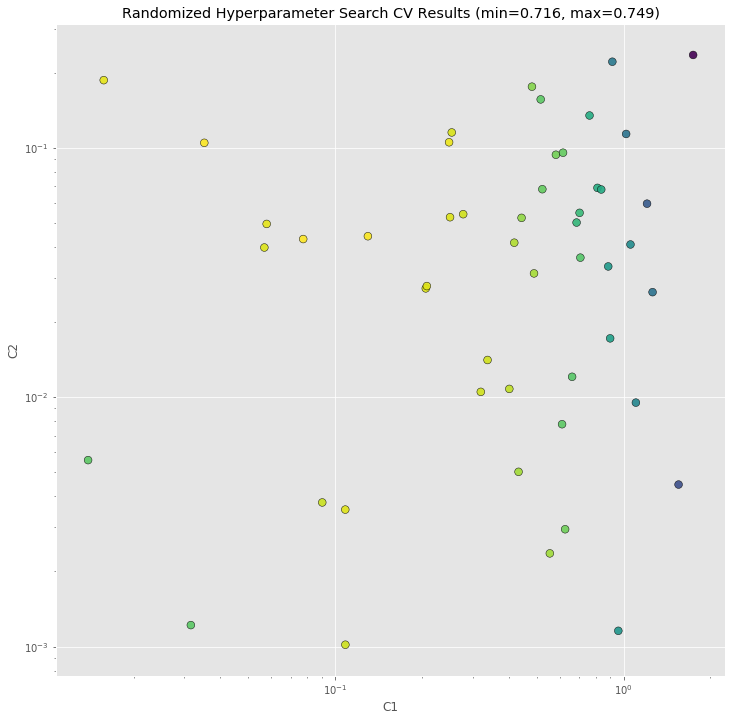

In [90]:
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])
# Red color means better results, blue means worse.
print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

## Check best estimator on our test data

In [85]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

       B-LOC      0.810     0.777     0.793      1084
       I-LOC      0.706     0.622     0.661       325
      B-MISC      0.729     0.555     0.630       339
      I-MISC      0.685     0.569     0.622       557
       B-ORG      0.804     0.834     0.819      1400
       I-ORG      0.833     0.793     0.813      1104
       B-PER      0.845     0.882     0.863       735
       I-PER      0.894     0.943     0.918       634

   micro avg      0.808     0.783     0.796      6178
   macro avg      0.788     0.747     0.765      6178
weighted avg      0.804     0.783     0.792      6178



## Check what classifier learned

In [87]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
B-ORG  -> I-ORG   7.588790
I-ORG  -> I-ORG   7.271036
B-MISC -> I-MISC  7.050971
I-MISC -> I-MISC  6.973025
B-PER  -> I-PER   6.527931
B-LOC  -> I-LOC   5.883021
I-LOC  -> I-LOC   5.054962
I-PER  -> I-PER   4.939507
O      -> O       4.149549
O      -> B-ORG   2.893228
O      -> B-PER   2.709838
O      -> B-LOC   2.164612
O      -> B-MISC  1.775813
B-LOC  -> B-LOC   0.484840
B-ORG  -> O       0.453982
I-PER  -> B-LOC   0.424530
B-ORG  -> B-LOC   0.327037
B-MISC -> B-ORG   0.041397
B-MISC -> O       -0.098289
B-MISC -> B-LOC   -0.183938

Top unlikely transitions:
I-MISC -> I-ORG   -2.412158
B-ORG  -> B-ORG   -2.436747
B-ORG  -> I-LOC   -2.521313
I-MISC -> B-LOC   -2.525378
I-LOC  -> B-MISC  -2.616353
I-ORG  -> I-PER   -2.688950
I-PER  -> I-LOC   -2.760027
B-PER  -> B-MISC  -2.976920
I-PER  -> B-ORG   -3.070465
I-ORG  -> I-LOC   -3.142490
I-ORG  -> B-MISC  -3.214138
B-ORG  -> B-MISC  -3.248323
I-MISC -> I-LOC   -3.259442
B-PER  -> B-PER   -3.391948
I-PER  -> B-MIS

In [88]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
11.802948 B-ORG    word.lower():efe-cantabria
10.219057 B-ORG    word.lower():psoe-progresistas
7.911949 B-ORG    word.lower():petrobras
7.668981 I-ORG    -1:word.lower():l
6.981582 B-ORG    word.lower():coag-extremadura
6.631365 I-ORG    -1:word.lower():rasd
6.209872 B-LOC    +1:word.lower():finalizaron
6.103418 B-ORG    +1:word.lower():plasencia
6.015153 B-ORG    -1:word.lower():distancia
5.965966 B-ORG    word.lower():xfera
5.807668 B-LOC    -1:word.lower():cantabria
5.721865 B-MISC   word.lower():diversia
5.716259 B-ORG    word[-2:]:-e
5.683790 B-LOC    -1:word.lower():celebrarán
5.656511 B-ORG    -1:word.lower():sociolaboral
5.611321 O        word.lower():r.
5.611321 O        word[-3:]:R.
5.604501 B-MISC   word.lower():justicia
5.589095 I-ORG    -1:word.lower():ag
5.496731 B-ORG    word.lower():terra
5.485477 B-ORG    word.lower():telefónica
5.477931 B-ORG    word.lower():esquerra
5.468152 O        BOS
5.448433 B-PER    word.lower():orduña
5.439149 B-ORG    word.lowe